In [15]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping


In [16]:
# Load dataset
data = pd.read_csv("electricity_load_forecasting.csv")

# Convert datetime column
data['datetime'] = pd.to_datetime(data['datetime'])

# Ensure correct column name
data.rename(columns={'load': 'Load'}, inplace=True)

# Sort and check
data = data.sort_values('datetime').reset_index(drop=True)
print(data.head())
print(f"✅ Data shape: {data.shape}")


             datetime  Load
0 2025-01-01 00:00:00  1234
1 2025-01-01 01:00:00  1250
2 2025-01-01 02:00:00  1270
3 2025-01-01 03:00:00  1300
4 2025-01-01 04:00:00  1290
✅ Data shape: (22, 2)


In [17]:
# Scale the data
scaler = MinMaxScaler()
load_scaled = scaler.fit_transform(data[['Load']])

# Define sequence length
SEQ_LENGTH = 5

# Function to create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    X, y = np.array(X), np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    return X, y

X, y = create_sequences(load_scaled, SEQ_LENGTH)
print(f"✅ X shape: {X.shape}, y shape: {y.shape}")


✅ X shape: (17, 5, 1), y shape: (17, 1)


In [18]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [19]:
model_path = "results/bfeemd_lstm_model.h5"
os.makedirs("results", exist_ok=True)

try:
    if os.path.exists(model_path):
        print("📂 Loading existing model...")
        model = load_model(model_path, compile=False)
        model.compile(optimizer='adam', loss='mse')
        print("✅ Model loaded and recompiled successfully!")
    else:
        raise FileNotFoundError
except Exception as e:
    print(f"⚠️ Model load failed: {e}")
    print("🔁 Retraining model...")

    model = Sequential([
        Input(shape=(SEQ_LENGTH, 1)),
        LSTM(64, activation='relu', return_sequences=False),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')

    es = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=30, batch_size=8, callbacks=[es])
    model.save(model_path)
    print("✅ Model trained and saved successfully!")


⚠️ Model load failed: 
🔁 Retraining model...
Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 30s 347ms/step - loss: 0.2722
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - loss: 0.2574
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - loss: 0.2446
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.2320
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.2210 
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.2092 
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - loss: 0.1987
Epoch 8/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - loss: 0.1888
Epoch 9/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.1780 
Epoch 10/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.1702
Epoch 11/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.1615
Epoch 12/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.1517
Epoch 13/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.1447
Epoch 14/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.1340
Epoch 15/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135

✅ Model trained and saved successfully!


In [ ]:
pred = model.predict(X_test)
pred_inverse = scaler.inverse_transform(pred)
actual_inverse = scaler.inverse_transform(y_test)

plt.figure(figsize=(10,5))
plt.plot(actual_inverse, label='Actual Load')
plt.plot(pred_inverse, label='Predicted Load')
plt.title("Actual vs Predicted Electricity Load")
plt.xlabel("Time Steps")
plt.ylabel("Load")
plt.legend()
plt.show()


In [21]:
last_sequence = load_scaled[-SEQ_LENGTH:].reshape(1, SEQ_LENGTH, 1)
next_pred = model.predict(last_sequence)
next_load = scaler.inverse_transform(next_pred)
print(f"🔹 Predicted Load for next hour: {next_load[0][0]:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
🔹 Predicted Load for next hour: 1422.16


In [25]:
print("Enter last 5 electricity load values (separated by space):")
user_input = list(map(float, input().split()))
if len(user_input) != SEQ_LENGTH:
    print(f"❌ Please enter exactly {SEQ_LENGTH} values.")
else:
    scaled_input = scaler.transform(np.array(user_input).reshape(-1, 1))
    X_input = scaled_input.reshape(1, SEQ_LENGTH, 1)
    next_pred = model.predict(X_input)
    next_load = scaler.inverse_transform(next_pred)
    print(f"⚡ Predicted Load for next hour: {next_load[0][0]:.2f}")


Enter last 5 electricity load values (separated by space):


 345


❌ Please enter exactly 5 values.


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


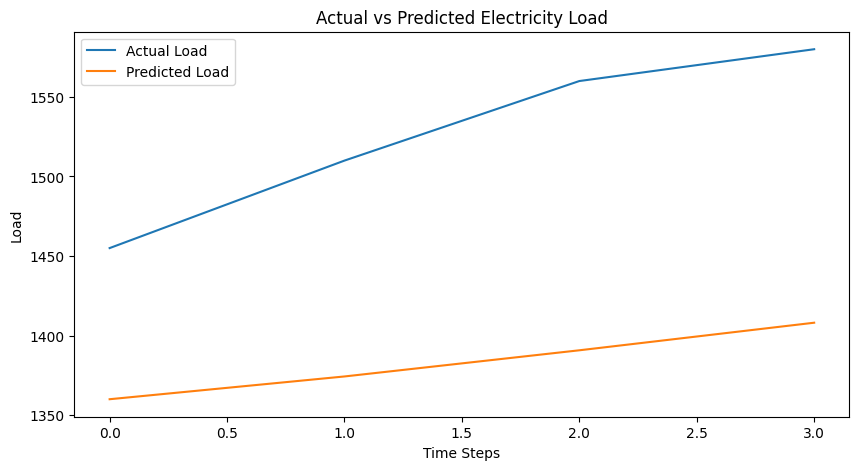

In [27]:
pred = model.predict(X_test)
pred_inverse = scaler.inverse_transform(pred)
actual_inverse = scaler.inverse_transform(y_test)

plt.figure(figsize=(10,5))
plt.plot(actual_inverse, label='Actual Load')
plt.plot(pred_inverse, label='Predicted Load')
plt.title("Actual vs Predicted Electricity Load")
plt.xlabel("Time Steps")
plt.ylabel("Load")
plt.legend()
plt.show()


In [33]:
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import MeanSquaredError

# Load model with custom_objects to handle old metrics
model = load_model("results/bfeemd_lstm_model.h5", 
                   custom_objects={"mse": MeanSquaredError})
print("✅ Model loaded")


✅ Model loaded


In [34]:
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


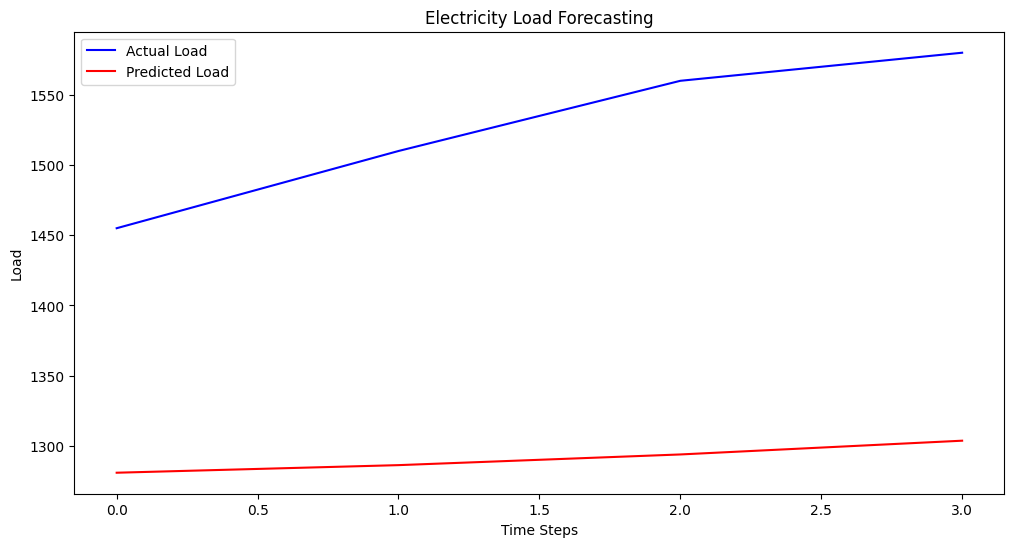

In [35]:
import matplotlib.pyplot as plt

# Assuming you have these already:
# y_test_inv -> actual load values (inverse scaled)
# y_pred_inv -> predicted load values (inverse scaled)

# Plot actual vs predicted electricity load
plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label='Actual Load', color='blue')
plt.plot(y_pred_inv, label='Predicted Load', color='red')
plt.title("Electricity Load Forecasting")
plt.xlabel("Time Steps")
plt.ylabel("Load")
plt.legend()
plt.show()


In [41]:
SEQ_LENGTH = 5  # last 5 hours
X_input = load_scaled[-SEQ_LENGTH:]  # last 5 values
X_input = X_input.reshape((1, SEQ_LENGTH, 1))  # LSTM expects 3D input

y_pred_scaled = model.predict(X_input)
y_pred = scaler.inverse_transform(y_pred_scaled)  # convert back to original scale

print(f"✅ Predicted electricity load for next hour: {y_pred[0][0]:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
✅ Predicted electricity load for next hour: 1313.22


In [43]:
future_hours = 5  # number of hours to predict
SEQ_LENGTH = 5    # length of input sequence

# Start with last SEQ_LENGTH points (as a flat array)
X_input = load_scaled[-SEQ_LENGTH:].reshape(-1).tolist()
predictions_scaled = []

for _ in range(future_hours):
    # Convert last SEQ_LENGTH values to proper shape (1, SEQ_LENGTH, 1)
    X_seq = np.array(X_input[-SEQ_LENGTH:]).reshape(1, SEQ_LENGTH, 1)
    y_pred_scaled = model.predict(X_seq)
    predictions_scaled.append(y_pred_scaled[0][0])
    X_input.append(y_pred_scaled[0][0])  # append prediction for next step

# Inverse transform to original scale
predictions = scaler.inverse_transform(np.array(predictions_scaled).reshape(-1,1))

# Display predictions
for i, val in enumerate(predictions, 1):
    print(f"Predicted load for hour +{i}: {val[0]:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
Predicted load for hour +1: 1313.22
Predicted load for hour +2: 1312.97
Predicted load for hour +3: 1309.39
Predicted load for hour +4: 1302.38
Predicted load for hour +5: 1291.90


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 908ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


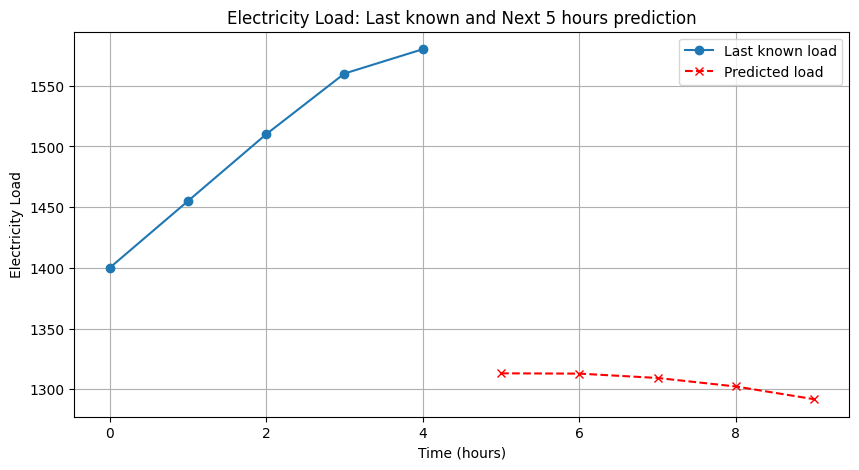

In [44]:
import numpy as np
import matplotlib.pyplot as plt

future_hours = 5   # predict next 5 hours
SEQ_LENGTH = 5     # length of input sequence

# Prepare input from last SEQ_LENGTH points
X_input = load_scaled[-SEQ_LENGTH:].reshape(-1).tolist()
predictions_scaled = []

for _ in range(future_hours):
    X_seq = np.array(X_input[-SEQ_LENGTH:]).reshape(1, SEQ_LENGTH, 1)
    y_pred_scaled = model.predict(X_seq)
    predictions_scaled.append(y_pred_scaled[0][0])
    X_input.append(y_pred_scaled[0][0])  # append for next prediction

# Inverse transform to original scale
predictions = scaler.inverse_transform(np.array(predictions_scaled).reshape(-1,1))

# Prepare data for plotting: last known points + predicted points
last_known = scaler.inverse_transform(load_scaled[-SEQ_LENGTH:].reshape(-1,1))
combined = np.vstack([last_known, predictions])

# Plot
plt.figure(figsize=(10,5))
plt.plot(range(len(last_known)), last_known, marker='o', label='Last known load')
plt.plot(range(len(last_known), len(combined)), predictions, marker='x', linestyle='--', color='red', label='Predicted load')
plt.xlabel("Time (hours)")
plt.ylabel("Electricity Load")
plt.title("Electricity Load: Last known and Next 5 hours prediction")
plt.legend()
plt.grid(True)
plt.show()


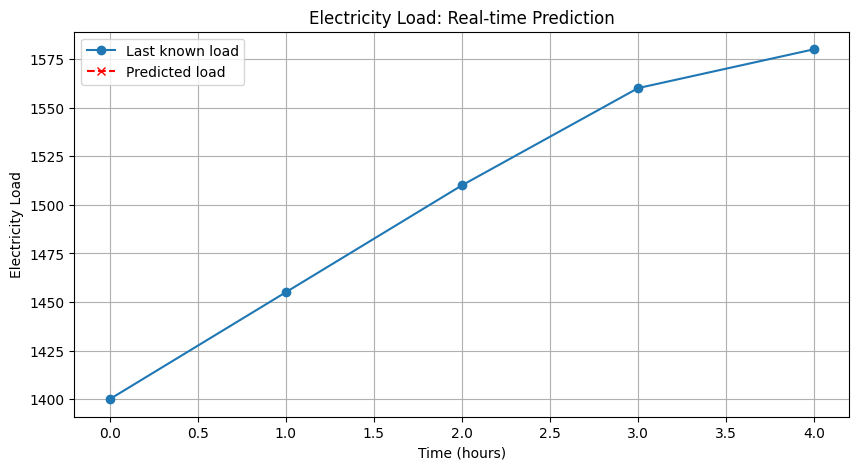

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


In [45]:
import numpy as np
import matplotlib.pyplot as plt
import time

future_hours = 5   # predict next 5 hours
SEQ_LENGTH = 5     # length of input sequence

# Prepare input from last SEQ_LENGTH points
X_input = load_scaled[-SEQ_LENGTH:].reshape(-1).tolist()
predictions_scaled = []

plt.ion()  # interactive mode on
fig, ax = plt.subplots(figsize=(10,5))

# Start with last known points
last_known = scaler.inverse_transform(load_scaled[-SEQ_LENGTH:].reshape(-1,1))
combined = last_known.copy()

line1, = ax.plot(range(len(last_known)), last_known, marker='o', label='Last known load')
line2, = ax.plot([], [], marker='x', linestyle='--', color='red', label='Predicted load')

ax.set_xlabel("Time (hours)")
ax.set_ylabel("Electricity Load")
ax.set_title("Electricity Load: Real-time Prediction")
ax.legend()
ax.grid(True)
plt.show()

# Predict next hours one by one
for i in range(future_hours):
    X_seq = np.array(X_input[-SEQ_LENGTH:]).reshape(1, SEQ_LENGTH, 1)
    y_pred_scaled = model.predict(X_seq)
    predictions_scaled.append(y_pred_scaled[0][0])
    X_input.append(y_pred_scaled[0][0])  # append for next prediction

    # Inverse transform and update plot
    predictions = scaler.inverse_transform(np.array(predictions_scaled).reshape(-1,1))
    combined = np.vstack([last_known, predictions])

    line2.set_data(range(len(last_known), len(combined)), predictions)
    ax.set_xlim(0, len(combined)+1)
    ax.set_ylim(0, combined.max()+10)
    fig.canvas.draw()
    fig.canvas.flush_events()
    time.sleep(1)  # pause 1 sec for animation effect

plt.ioff()
plt.show()


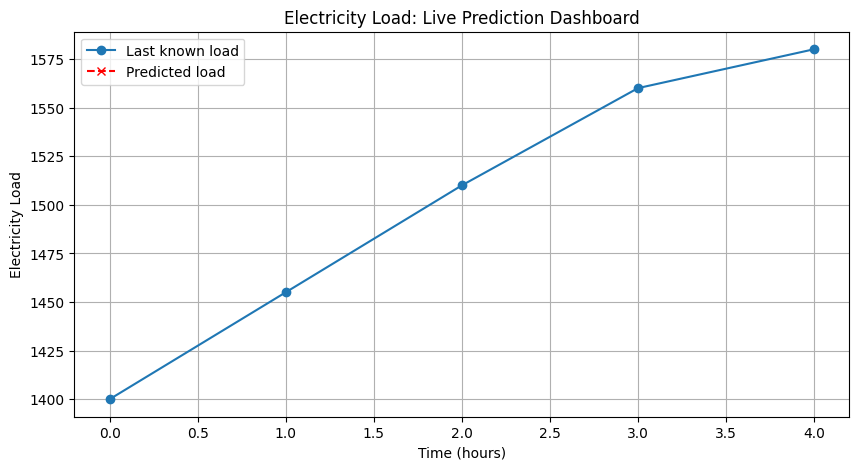

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


In [46]:
import numpy as np
import matplotlib.pyplot as plt
import time

future_hours = 5
SEQ_LENGTH = 5

# Prepare input from last SEQ_LENGTH points
X_input = load_scaled[-SEQ_LENGTH:].reshape(-1).tolist()
predictions_scaled = []

# Initialize plot
plt.ion()
fig, ax = plt.subplots(figsize=(10,5))

# Last known data
last_known = scaler.inverse_transform(load_scaled[-SEQ_LENGTH:].reshape(-1,1))
combined = last_known.copy()

line1, = ax.plot(range(len(last_known)), last_known, marker='o', label='Last known load')
line2, = ax.plot([], [], marker='x', linestyle='--', color='red', label='Predicted load')

ax.set_xlabel("Time (hours)")
ax.set_ylabel("Electricity Load")
ax.set_title("Electricity Load: Live Prediction Dashboard")
ax.legend()
ax.grid(True)

plt.show()

# Predict and scroll
for i in range(future_hours):
    # Prepare input sequence
    X_seq = np.array(X_input[-SEQ_LENGTH:]).reshape(1, SEQ_LENGTH, 1)
    y_pred_scaled = model.predict(X_seq)
    predictions_scaled.append(y_pred_scaled[0][0])
    X_input.append(y_pred_scaled[0][0])

    # Inverse scale predictions
    predictions = scaler.inverse_transform(np.array(predictions_scaled).reshape(-1,1))
    combined = np.vstack([last_known, predictions])

    # Update plot
    line2.set_data(range(len(last_known), len(combined)), predictions)

    # Scroll x-axis dynamically
    ax.set_xlim(max(0, len(combined)-10), len(combined)+1)
    ax.set_ylim(0, combined.max()+10)

    fig.canvas.draw()
    fig.canvas.flush_events()
    time.sleep(1)

plt.ioff()
plt.show()


In [47]:
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython.display import display, clear_output
import pandas as pd

future_hours = 5
SEQ_LENGTH = 5

# Prepare input from last SEQ_LENGTH points
X_input = load_scaled[-SEQ_LENGTH:].reshape(-1).tolist()
predictions_scaled = []

# Last known data (inverse scaled)
last_known = scaler.inverse_transform(load_scaled[-SEQ_LENGTH:].reshape(-1,1))
combined = last_known.copy()

# Initialize plot
plt.ion()
fig, ax = plt.subplots(figsize=(10,5))

line1, = ax.plot(range(len(last_known)), last_known, marker='o', label='Last known load')
line2, = ax.plot([], [], marker='x', linestyle='--', color='red', label='Predicted load')

ax.set_xlabel("Time (hours)")
ax.set_ylabel("Electricity Load")
ax.set_title("Electricity Load: Live Prediction Dashboard")
ax.legend()
ax.grid(True)

plt.show()

# Predict and update graph + table
for i in range(future_hours):
    # Prepare input sequence
    X_seq = np.array(X_input[-SEQ_LENGTH:]).reshape(1, SEQ_LENGTH, 1)
    y_pred_scaled = model.predict(X_seq, verbose=0)
    predictions_scaled.append(y_pred_scaled[0][0])
    X_input.append(y_pred_scaled[0][0])

    # Inverse scale predictions
    predictions = scaler.inverse_transform(np.array(predictions_scaled).reshape(-1,1))
    combined = np.vstack([last_known, predictions])

    # Update plot
    line2.set_data(range(len(last_known), len(combined)), predictions)
    ax.set_xlim(max(0, len(combined)-10), len(combined)+1)
    ax.set_ylim(0, combined.max()+10)
    fig.canvas.draw()
    fig.canvas.flush_events()

    # Display table of predictions
    clear_output(wait=True)
    df = pd.DataFrame({
        "Hour": list(range(1, len(predictions)+1)),
        "Predicted Load": np.round(predictions.flatten(),2)
    })
    print("Predicted Electricity Load for Next Hours:")
    display(df)
    
    time.sleep(1)

plt.ioff()
plt.show()


Predicted Electricity Load for Next Hours:


,Hour,Predicted Load
0,1,1313.219971
1,2,1312.969971
2,3,1309.380005
3,4,1302.380005
4,5,1291.900024


In [48]:
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython.display import display, clear_output
import pandas as pd

# Ask user for how many future hours to predict
future_hours = int(input("Enter number of future hours to predict: "))

SEQ_LENGTH = 5

# Prepare input from last SEQ_LENGTH points
X_input = load_scaled[-SEQ_LENGTH:].reshape(-1).tolist()
predictions_scaled = []

# Last known data (inverse scaled)
last_known = scaler.inverse_transform(load_scaled[-SEQ_LENGTH:].reshape(-1,1))
combined = last_known.copy()

# Initialize plot
plt.ion()
fig, ax = plt.subplots(figsize=(10,5))

line1, = ax.plot(range(len(last_known)), last_known, marker='o', label='Last known load')
line2, = ax.plot([], [], marker='x', linestyle='--', color='red', label='Predicted load')

ax.set_xlabel("Time (hours)")
ax.set_ylabel("Electricity Load")
ax.set_title("Electricity Load: Live Prediction Dashboard")
ax.legend()
ax.grid(True)

plt.show()

# Predict and update graph + table
for i in range(future_hours):
    # Prepare input sequence
    X_seq = np.array(X_input[-SEQ_LENGTH:]).reshape(1, SEQ_LENGTH, 1)
    y_pred_scaled = model.predict(X_seq, verbose=0)
    predictions_scaled.append(y_pred_scaled[0][0])
    X_input.append(y_pred_scaled[0][0])

    # Inverse scale predictions
    predictions = scaler.inverse_transform(np.array(predictions_scaled).reshape(-1,1))
    combined = np.vstack([last_known, predictions])

    # Update plot
    line2.set_data(range(len(last_known), len(combined)), predictions)
    ax.set_xlim(max(0, len(combined)-10), len(combined)+1)
    ax.set_ylim(0, combined.max()+10)
    fig.canvas.draw()
    fig.canvas.flush_events()

    # Display table of predictions
    clear_output(wait=True)
    df = pd.DataFrame({
        "Hour": list(range(1, len(predictions)+1)),
        "Predicted Load": np.round(predictions.flatten(),2)
    })
    print(f"Predicted Electricity Load for Next {future_hours} Hours:")
    display(df)
    
    time.sleep(1)

plt.ioff()
plt.show()


Predicted Electricity Load for Next 10 Hours:


,Hour,Predicted Load
0,1,1313.219971
1,2,1312.969971
2,3,1309.380005
3,4,1302.380005
4,5,1291.900024
5,6,1279.420044
6,7,1278.439941
7,8,1277.510010
8,9,1276.680054
9,10,1276.020020
